[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OP_2025/blob/main/analysis_scripts/Virus_QC.ipynb)

# Clone github repo

In [ ]:
!git clone https://github.com/pachterlab/OP_2025.git
%cd /content/OP_2025/

# Download Data

In [ ]:
!mkdir omics_adata
!wget -O omics_adata/rat_RNA_meta.h5ad https://data.caltech.edu/records/j57wp-0pp06/files/rat_RNA_meta.h5ad?download=1
!wget -O omics_adata/virus_raw.h5ad https://data.caltech.edu/records/j57wp-0pp06/files/virus_raw.h5ad?download=1


# Install Packages

In [ ]:
!pip install -qr requirements.txt 

In [ ]:
# import packages

import os, sys
sys.path.append('../')

import time

# numbers
import numpy as np
import pandas as pd

# sc
import anndata as ad
import scanpy as sc

# plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from html2image import Html2Image
from PIL import Image

from rat_friend import *

# Load Virus Data

In [ ]:
palmdb_adata = ad.read_h5ad('omics_adata/virus_raw.h5ad')

# filter out bad samples and merge metadata
rat_adata = ad.read_h5ad("omics_adata/rat_RNA_meta.h5ad")
palmdb_adata.obs = pd.merge(palmdb_adata.obs, rat_adata.obs.reset_index(), on='barcode', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
palmdb_adata.obs = palmdb_adata.obs.drop(['outlier', 'original_out'],axis=1)
palmdb_adata = palmdb_adata[~palmdb_adata.obs.old_tissue.isna()]
palmdb_adata.obs['time'] = palmdb_adata.obs.time.values.astype('int')
palmdb_adata

/tmp/ipykernel_1993445/2915500917.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  palmdb_adata.obs['time'] = palmdb_adata.obs.time.values.astype('int')
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 861 × 99228
    obs: 'barcode', 'index', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'old_tissue'
    var: 'genes'

Add Virus Metadata

In [ ]:
# Load virus ID to taxonomy mapping
id2tax = pd.read_csv("metadata_csvs/ID_to_taxonomy_mapping.csv")

# Drop columns not needed here and drop taxonomyduplicates
id2tax = id2tax.drop("ID", axis=1).drop("strandedness", axis=1)
id2tax = id2tax.drop_duplicates()


#filter for common contaminants
bkg_virs_df = pd.read_csv("metadata_csvs/total_raw_count_per_virus_id_in_laboratory_reagents.csv")

id2tax['contaminate'] = [vid in list(bkg_virs_df['virus']) for vid in id2tax['rep_ID']]
id2tax['known'] = id2tax['species']!='.'


palmdb_adata.var = (
        palmdb_adata
        .var.merge(id2tax, left_on="genes", right_on="rep_ID", how="left")
        .set_index("genes", drop=True)
    )
palmdb_adata.var

,rep_ID,phylum,class,order,family,genus,species,contaminate,known
genes,,,,,,,,,
u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,False,True
u10,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,False,True
u100,u100,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,West Nile virus,False,True
u102,u102,Kitrinoviricota,Alsuviricetes,Hepelivirales,Hepeviridae,Orthohepevirus,Orthohepevirus A,False,True
u113,u113,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Morbillivirus,Measles morbillivirus,False,True
...,...,...,...,...,...,...,...,...,...
u296608,u296608,.,.,.,.,.,.,True,False
u296609,u296609,.,.,.,.,.,.,False,False
u296613,u296613,.,.,.,.,.,.,False,False


# See Distribution of Counts Across Cells

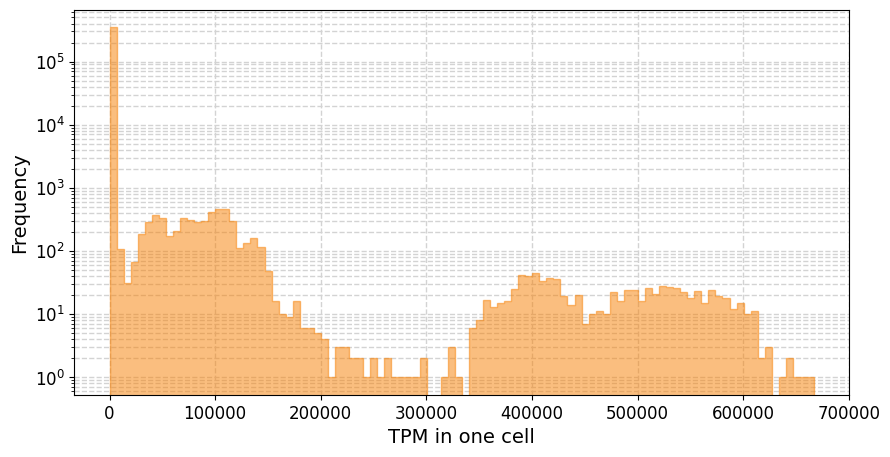

In [5]:
palmdb_adata_temp = palmdb_adata.X
vir_counts = nd(palmdb_adata_temp[palmdb_adata_temp>0])

fig, ax = plt.subplots(figsize=(10, 5))
fontsize = 14

ax.hist(vir_counts, bins=100, histtype='stepfilled', edgecolor="#f77f00", facecolor="#f77f00", alpha=0.5, log=True)

ax.set_xlabel("TPM in one cell", fontsize=fontsize)
ax.set_ylabel("Frequency", fontsize=fontsize)

# Change fontsize of tick labels
ax.tick_params(axis="both", labelsize=fontsize-2)

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

fig.show()

# See Distribution of Cells with Virus

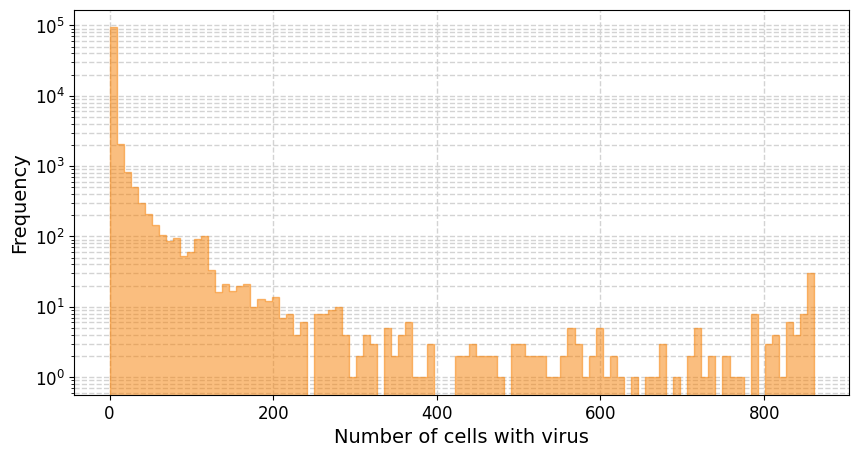

In [6]:
palmdb_adata_temp = palmdb_adata.X>0
vir_counts = nd(palmdb_adata_temp.sum(axis=0))

fig, ax = plt.subplots(figsize=(10, 5))
fontsize = 14

ax.hist(vir_counts, bins=100, histtype='stepfilled', edgecolor="#f77f00", facecolor="#f77f00", alpha=0.5, log=True)


ax.set_xlabel("Number of cells with virus", fontsize=fontsize)
ax.set_ylabel("Frequency", fontsize=fontsize)

# Change fontsize of tick labels
ax.tick_params(axis="both", labelsize=fontsize-2)

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

plt.savefig("count_histogram.png", dpi=300, bbox_inches="tight")

fig.show()

# See number of known/unknown/contaminate viruses are present

In [7]:
sc.pp.filter_genes(palmdb_adata,min_counts=1)
vir_virs = palmdb_adata.var.rep_ID
con_virs = bkg_virs_df['virus']
ukn_virs = id2tax[id2tax['phylum']=='.']['rep_ID']
kn_virs = id2tax[id2tax['phylum']!='.']['rep_ID']

known_virs = list(set(vir_virs).intersection(set(kn_virs)))
mixed_virs = list(set(vir_virs).intersection(set(con_virs)))
mixed_ukn_virs = list(set(vir_virs).difference(con_virs).intersection(set(kn_virs)))

print("Number of viruses: ", len(vir_virs))
print("Number of 'known' viruses: ", len(known_virs))
print("Number of 'contamination' viruses: ", len(mixed_virs))
print("Number of 'known' non-contamination viruses: ", len(mixed_ukn_virs))

Number of viruses:  31833
Number of 'known' viruses:  1072
Number of 'contamination' viruses:  1075
Number of 'known' non-contamination viruses:  1061


# Filter Virus

In [ ]:
palmdb_adata.write("omics_adata/virus_post_qc.h5ad")
# require virus in 200+ samples
sc.pp.filter_genes(palmdb_adata,min_counts=200)
palmdb_adata.write("omics_adata/virus_filtered.h5ad")
palmdb_adata

AnnData object with n_obs × n_vars = 861 × 1492
    obs: 'barcode', 'index', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'old_tissue'
    var: 'rep_ID', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'contaminate', 'known', 'n_counts'

# Visualize Distribution of Filtered Virus with Krona Plot

In [9]:
%%time
ktImportText = "KronaTools-2.8.1/bin/ktImportText"
palmdb_adata.var['total_counts'] = palmdb_adata.X.toarray().sum(axis=0)

master = pd.DataFrame()
for idx, timepoint in enumerate([0, 1, 2, 4, 8]):
    for sex in palmdb_adata.obs[palmdb_adata.obs["time"] == timepoint]["sex"].unique():
        adata_temp = palmdb_adata[(palmdb_adata.obs["time"] == timepoint) & (palmdb_adata.obs["sex"] == sex), :]
    
        # Add total number of counts (across all cells) for each virus ID to phylogeny data temp
        virus_ids = adata_temp.var.rep_ID
        total_counts = nd(adata_temp.X.sum(axis=0))
        total_count_dict = {virus_ids[i]: total_counts[i] for i in range(len(virus_ids))}
    
        #phylogeny_data_temp = filtered_id2tax.copy()
        phylogeny_data_temp = palmdb_adata.var
        phylogeny_data_temp['total_count'] = phylogeny_data_temp['rep_ID'].map(total_count_dict)
    
        # Drop viruses not in filter list
        phylogeny_data_temp = phylogeny_data_temp.dropna()
    
        # Remove non-relevent columns and change order of columns
        phylogeny_data_temp = phylogeny_data_temp[["total_count", "phylum", "class", "order", "family", "genus", "species", "rep_ID"]]
    
        # Replace dots with NaN
        #phylogeny_data_temp = phylogeny_data_temp.replace(".", np.nan)
    
        # Add column with timepoint
        phylogeny_data_temp["timepoint"] = timepoint
        phylogeny_data_temp["sex"] = sex
    
        # Append to master dataframe
        if idx == 0:
            master = phylogeny_data_temp.copy()
            idx += 1
        else:
            master = pd.concat([master, phylogeny_data_temp])

# Save counts + taxnomomies data to txt
master.to_csv(f'krona.txt', sep ='\t', header=None, index=False)

# Generate Krona plot
krona_out = "krona.html"
!$ktImportText krona.txt -o $krona_out -n "Virus-positive cells"

<timed exec>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<tim

Writing krona.html...
CPU times: user 392 ms, sys: 76.4 ms, total: 468 ms
Wall time: 1.46 s
